# CIS 5450 Project: Open Food Fact Data Analysis

Team members: Baojia Liu, Xiaoyong Cai (Wesley) , Ramanpreet Bhatia


# Introduction

As consumers, we care about what we eat every day and what we give to our children. We created models to predict nutrition grade/scores for the products  and our project could give recommendations based on nutrition scores which will help people make better choices for similar food items.

We also care about food products that are high in sugar or other nutrients that might not be healthy for long-term and excessive consumption. Considering there are alternative nutritional foods available, we would like choose food products with better nutrition scores. 

# 0 Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import sequence
spark = SparkSession.builder.master("local[*]").getOrCreate()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


# 1 Data Loading and Preprocessing



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



## 1.1 Partitioning Open Food Facts Dataset

Initialily, we have trouble loading the fulll dataset (7 GB+, 2M+ rows) using pandas due to the restriction of free colab. We have partitioned the whole dataset into 10 files for early research and conducting speed analysis.

In [4]:
# # Row Partitioning
# # Notes: please update the input_dir & output_dir before running
# input_dir = "drive/My Drive/545_project/data/en.openfoodfacts.org.products.csv" 
# output_dir = "drive/My Drive/545_project/data/partitions/"

# num_partitions = 10

# for r in range(num_partitions):
#   print("working on ",r," th partition job")
#   i = 0
#   text = ""
#   with open(input_dir, encoding='UTF-8') as f:
#     header = f.readline()
#     text += header

#     while True:
#       line = f.readline()
#       if not line:
#           break

#       # The remainder (row index divide by num_partitions) would decide which partition file go to
#       if i % num_partitions == r:
#         text += line
#       i += 1

#   output_filename = output_dir + "p"+ str(r) +".csv"
#   with open(output_filename, 'w', encoding='UTF8') as f:
#     f.write(text)

## 1.2  Dataset Open Food Facts


The dataset we used for this project is from Open Food Facts (https://world.openfoodfacts.org/data). We downloaded the most recent csv file and saved it into google drive. The full dataset contains 196 columns * 2640596 rows.

In [5]:
# Load data from Google Drive

path = "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/en.openfoodfacts.org.products.csv" 

df = spark.read.option("encoding", "UTF-8").option("delimiter", "\t").option("header", "True").csv(path)
df.show()
df.count()
# len(df.columns)

+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------------+-------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------

2640596

To clean up the data, since we used the 'product_name' column as the key coulmn, we dropped any rows without a product name. We kept all the other 2547006 rows for now.





In [6]:
# Drop rows with NaN in 'product_name' column and keep all the other rows for now. 

df = df.na.drop(subset=["product_name"])
df.show()
df.count()


+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------------+-------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------

2547006

To clean the columns, since the dataset contains a large number of NaN values, we set a threshold as 5% and dropped any columns with less than 5% coverage. We kept all the other 89 columns for now. Saved the new dataset into new_df.

In [7]:
# Get the ratio of null values in each column
from pyspark.sql.functions import col, count, isnan, lit, sum

def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True ->  1
    """
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

df.agg(*[count_not_null(c) for c in df.columns]).show()
exprs = [(count_not_null(c) / count("*")).alias(c) for c in df.columns]
df_null_ratio = df.agg(*exprs)
df_null_ratio.show()

+-------+-------+-------+---------+----------------+---------------+----------------------+------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------+-----------+----------+---------------+-------------+-------+------------+----------+--------------------+-------------------------+------+-----------+---------+---------+--------------+------------------------+------+-----------+---------------+------+---------+--------------+------------+----------------+----------------+-------------------------+---------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------+------------+----------------+----------------+----------+-------------+-------------+-----------+----------------+--------------+-------+-----------+---------+-----------+--------------+--------------+--------------------+----------------+-----+------------------------+--------------+---------------+--

In [8]:
# Drop columns with < 5% coverage
ratios = df_null_ratio.select(*[c for c in df.columns]).first()
cols_to_drop = [c for c in ratios.asDict() if ratios[c] < 0.05]
new_df = df.drop(*cols_to_drop)
new_df.show()
new_df.count()
len(new_df.columns)

+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------+--------+---------+--------------+------------+-------------+-------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+-----------+---------+------------+----------------+-----------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+--------------+--------------------+----------------+--------------+--------

89

# 2 EDA

## 2.1 Average nutrition score

We would like to see the overall nutriscore in different countries. We think the best way to visualize it in a world map and show their average nutriscore.

In [9]:
# remove rows with null nutriscore_score or nutriscore_grade
df_2 = new_df.filter((new_df.nutriscore_grade.isNotNull()) & (new_df.nutriscore_score.isNotNull()))
df_2.show()

+--------------------+--------------------+---------------+----------+--------------------+---------------+----------------------+--------------------+------------+--------+--------------------+------------------+------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------------+----------------+----------------+----------+--------------+---------------+-------------+-------------+----------------+-------------+--------------------+--------------------+-------------------------+-----------------+-----------------+-----------+---------------+----------------+-----------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+--------------+-----------

In [10]:
# generate average nutrition score for countries
df_2.createOrReplaceTempView("df_2")

sdf = spark.sql('''
SELECT countries_en,nutriscore_score
FROM df_2
''')
score_countries_pdf = sdf.toPandas().astype({'nutriscore_score':'int32'})

# "countries_en" is a column that has multiply values,so we exploded it and get single value.
score_countries_pdf['country'] = score_countries_pdf["countries_en"].str.split(",")
score_countries_pdf = score_countries_pdf.explode("country")
# score_countries_pdf.head()

# calculate the mean nutriscore for each country
ave_score_df = score_countries_pdf.dropna(subset=['nutriscore_score']).groupby(['country'])['nutriscore_score'].mean().reset_index()
ave_score_df.head()

,country,nutriscore_score
0,Afganistan,18.000000
1,Afghanistan,9.719298
2,Afrique-du-sud,27.000000
3,Agypten,26.000000
4,Albania,10.650000


In [11]:
# data preprocess for wolrd map plotting
ave_score_max = ave_score_df['nutriscore_score'].max()
ave_score_list = [[ave_score_df['country'][i],round(ave_score_df['nutriscore_score'][i], 2)] for i in range(len(ave_score_df))] #prepare data for visualization
print(ave_score_list[:3])

[['Afganistan', 18.0], ['Afghanistan', 9.72], ['Afrique-du-sud', 27.0]]


In [12]:
!pip install pyecharts
from pyecharts.charts import Map,Geo
from pyecharts import options as opts
from pyecharts.globals import ThemeType
import IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
map_1 = Map(init_opts=opts.InitOpts(width='1400', height='600px')) #create the map and set the size of the map
map_1.add('Average Nutriscore Score', ave_score_list, maptype='world') #add world map
map_1.set_series_opts(label_opts=opts.LabelOpts(is_show=False)) #remove country names
map_1.set_global_opts( #set global configurations
 title_opts=opts.TitleOpts(title="Nutriscore In Different Countries"),
 visualmap_opts=opts.VisualMapOpts( max_=ave_score_max,  is_piecewise=False),
 legend_opts=opts.LegendOpts(is_show=False), #show legend or not
 )
# map_1.render_notebook() #show the map in the notebook directly
map_1.render('ave_score.html')
IPython.display.HTML(filename='ave_score.html')

## 2.2 Organic food vs. non-organic food

Organic food is considered to be safer, heathier than non-organic food, and it usually has a higher price. We wanted to study the open food dataset to see if organic food does have a better nutrition score/grade compared to non-organic food. We analized the dataset by answering following three questions to get a better understanding of organic food.


1.   Do organic food products have a lower nutrition score (better score) than non-organic food products?
2.   Do organic food products have a better nutrition grade ('a' is the best, 'e' is the worst) than non-organic food products?
3.   The average values of some common nutrients in organic and non-organinc food.



### 2.2.1 Average nutrition score

Filtered out the rows with both nutrition score and nutrition grade, and calculated the average nutrition scores for organic and non-organic food. 

In [14]:
# # drop rows with null nutrition score or nutrition grade, save the new df into df_2
# df_2 = new_df.filter((new_df.nutriscore_grade.isNotNull()) & (new_df.nutriscore_score.isNotNull()))
# df_2.show()

In [15]:
# Organic food
df_2.createOrReplaceTempView("df_2")
sdf = spark.sql('''
SELECT AVG(nutriscore_score) AS organic_average_score 
FROM df_2 
WHERE labels_en = "Organic"
''')
sdf.show()

+---------------------+
|organic_average_score|
+---------------------+
|     6.02549829412821|
+---------------------+



In [16]:
# Non-organic food
sdf = spark.sql('''
SELECT AVG(nutriscore_score) AS non_organic_average_score 
FROM df_2 
WHERE labels_en <> "Organic"
''')
sdf.show()

+-------------------------+
|non_organic_average_score|
+-------------------------+
|        8.581500771604938|
+-------------------------+



We wonder if it is a significantly different between **organic** nutriscore_score (mean:6.026) and **non organic** nutriscore_score (mean: 8.587)

In [17]:
# generate organic nutrition scores
sdf_org = spark.sql('''
SELECT labels_en,nutriscore_score
FROM df_2 
WHERE labels_en = "Organic"
''')
df_org = sdf_org.toPandas().astype({'nutriscore_score':'int32'})
df_org.head()

,labels_en,nutriscore_score
0,Organic,5
1,Organic,-7
2,Organic,1
3,Organic,0
4,Organic,4


In [18]:
# generate non-organic nutrition scores
sdf_non_org = spark.sql('''
SELECT labels_en,nutriscore_score
FROM df_2 
WHERE labels_en <> "Organic"
''')
df_non_org = sdf_non_org.toPandas().astype({'nutriscore_score':'int32'})
df_non_org.head()

,labels_en,nutriscore_score
0,fr:delois-france,18
1,No palm oil,2
2,"French meat,Made in France",0
3,Green Dot,2
4,"Organic,EU Organic,Non-EU Agriculture,EU Agric...",0


We are conducting hypothesis test **t-test** using package **researchpy** and **Scipy.stats**
to test if it is a significantly difference between two scores.

**The null hypothese**: there is no difference 

In [19]:
!pip install researchpy
import researchpy as rp
import scipy.stats as stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
rp.ttest(group1= df_org['nutriscore_score'], group1_name= "Organic",
         group2= df_non_org['nutriscore_score'], group2_name= "Non_Organic")

# Ref: https://www.pythonfordatascience.org/independent-samples-t-test-python/

(      Variable         N      Mean        SD        SE  95% Conf.  Interval
 0      Organic   22276.0  6.025498  8.099221  0.054266   5.919134  6.131863
 1  Non_Organic  259200.0  8.581501  8.752799  0.017192   8.547805  8.615197
 2     combined  281476.0  8.379219  8.730161  0.016455   8.346967  8.411470,
                       Independent t-test      results
 0  Difference (Organic - Non_Organic) =       -2.5560
 1                  Degrees of freedom =   281474.0000
 2                                   t =      -42.0644
 3               Two side test p value =        0.0000
 4              Difference < 0 p value =        0.0000
 5              Difference > 0 p value =        1.0000
 6                           Cohen's d =       -0.2937
 7                           Hedge's g =       -0.2937
 8                      Glass's delta1 =       -0.3156
 9                    Point-Biserial r =       -0.0790)

**Interpretation:**

The average nutri score for organic, Mean = 6.025 (5.919134, 6.131863), was statistically signigicantly higher than non organic, Mean = 8.58 (8.547805, 8.615197); **t_statistic= -42.0644, p= 0.0000** (very small here)


From the results above we know organic food do have a better nutrition score than non-organic food products.

(Note: Smaller nutrition score tends to be better)

### 2.2.2 Nutrition grades

Visualize the distribution of nutrition grades for organic and non-organic food.

In [21]:
# Organic food grade distribution
sdf = spark.sql('''
SELECT nutriscore_grade, COUNT(*) AS cnt
FROM df_2
WHERE labels_en = "Organic"
GROUP BY 1
ORDER BY 1
''')
sdf.show()
pdf = sdf.select('*').toPandas()

+----------------+----+
|nutriscore_grade| cnt|
+----------------+----+
|               a|5332|
|               b|3862|
|               c|5137|
|               d|5355|
|               e|2590|
+----------------+----+



sum 22276


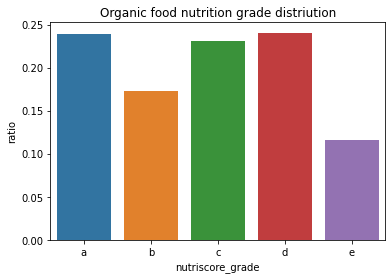

In [22]:
# visualize the organic distribution
import seaborn as sns
import matplotlib.pyplot as plt
s = pdf['cnt'].sum()
print('sum', s)
pdf['ratio'] = pdf['cnt'] / s
plt.figure()
ax = sns.barplot(data=pdf, x='nutriscore_grade', y='ratio')
plt.title("Organic food nutrition grade distriution")
plt.show()

In [23]:
# non-organic food nutrition grade distribution
sdf = spark.sql('''
SELECT nutriscore_grade, COUNT(*) AS cnt
FROM df_2
WHERE labels_en <> "Organic"
GROUP BY 1
ORDER BY 1
''')
sdf.show()
pdf = sdf.select('*').toPandas()

+----------------+-----+
|nutriscore_grade|  cnt|
+----------------+-----+
|               a|42602|
|               b|39677|
|               c|57168|
|               d|74371|
|               e|45382|
+----------------+-----+



sum 259200


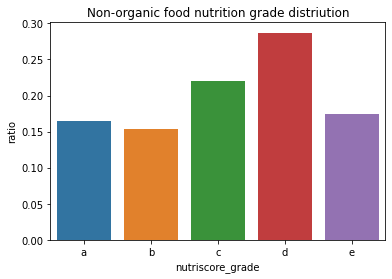

In [24]:
# # visualize the non-organic distribution
s = pdf['cnt'].sum()
print('sum', s)
pdf['ratio'] = pdf['cnt'] / s
pdf
plt.figure()
ax = sns.barplot(data=pdf, x='nutriscore_grade', y='ratio')
plt.title("Non-organic food nutrition grade distriution")
plt.show()

It is known from the results above, more than 40% of the the organic food products are in a or b, while there are around 30% of non-organic food products are in a or b grade. The difference of the ratio was notas much as we expected, but it is still the fact we got from the dataset that organic food is more likely to be in better nutrition grades in genreal.


### 2.2.3 Common nutriants average amount




We selected a few common nutrients and compare their average amount between organic and non-organic food. Since the dataset contain outlier, we remove the rows with extreme values and kept the rest for the analysis.

In [25]:
# calculate the average amount for each nutrient in orgnic food and non-organic food respectively
# remove the outlier
sdf = spark.sql('''
SELECT
    CASE
        WHEN labels_en = "Organic" THEN "Organic"
        ELSE "Non-organic"
    END AS type_of_food,
    AVG(`energy_100g`) AS `Avg_energy_100g`,
    AVG(`fat_100g`) AS `Avg_fat_100g`,
    AVG(`saturated-fat_100g`) AS `Avg_saturated-fat_100g`,
    AVG(`trans-fat_100g`) As `Avg_trans-fat_100g`,
    AVG(`cholesterol_100g`) AS `Avg_cholesterol_100g`,
    AVG(`carbohydrates_100g`) AS `Avg_carbohydrates_100g`,
    AVG(`sugars_100g`) AS `Avg_sugars_100g`,
    AVG(`fiber_100g`) AS `Avg_fiber_100g`,
    AVG(`proteins_100g`) AS `Avg_proteins_100g`,
    AVG(`salt_100g`) AS `Avg_salt_100g`,
    AVG(`sodium_100g`) AS `Avg_sodium_100g`,
    AVG(`vitamin-a_100g`) AS `Avg_vitamin-a_100g`,
    AVG(`vitamin-c_100g`) AS `Avg_vitamin-c_100g`,
    AVG(`calcium_100g`) AS `Avg_calcium_100g`,
    AVG(`iron_100g`) AS `Avg_iron_100g`,
    AVG(`fruits-vegetables-nuts-estimate-from-ingredients_100g`) AS `Avg_fruits-vegetables-nuts_100g`
FROM df_2
WHERE
    `energy_100g` < 4000 AND
    `fat_100g` < 100 AND
    `saturated-fat_100g` < 100 AND
    `trans-fat_100g` < 100 AND
    `cholesterol_100g` < 100 AND
    `carbohydrates_100g` < 100 AND
    `sugars_100g` < 100 AND
    `fiber_100g` < 100 AND
    `proteins_100g` < 100 AND
    `salt_100g` < 100 AND
    `sodium_100g` < 100 AND
    `vitamin-a_100g` < 100 AND
    `vitamin-c_100g` < 100 AND
    `calcium_100g` < 100 AND
    `iron_100g` < 100 AND
    `fruits-vegetables-nuts-estimate-from-ingredients_100g` < 100
GROUP BY 1 
''')
pdf = sdf.select('*').toPandas()
pdf

,type_of_food,Avg_energy_100g,Avg_fat_100g,Avg_saturated-fat_100g,Avg_trans-fat_100g,Avg_cholesterol_100g,Avg_carbohydrates_100g,Avg_sugars_100g,Avg_fiber_100g,Avg_proteins_100g,Avg_salt_100g,Avg_sodium_100g,Avg_vitamin-a_100g,Avg_vitamin-c_100g,Avg_calcium_100g,Avg_iron_100g,Avg_fruits-vegetables-nuts_100g
0,Organic,1005.716773,9.909529,3.201033,0.004560,0.017421,31.841789,11.159544,4.025925,7.040353,0.662699,0.265080,0.012961,0.009334,0.071143,0.001819,5.009504
1,Non-organic,1193.689685,13.189385,4.773718,0.041103,0.033971,34.420634,14.692608,2.654620,8.329011,1.245061,0.498024,0.021294,0.006325,0.098272,0.002099,2.929426


In [26]:
# caculate and compare the ratio of nutrition grades for organic and non-organic food 
nutritions = []
types = []
amounts = []
for i, c in enumerate(pdf.columns):
    if i == 0:
        continue
    row = pdf[c]
    nutritions.append(c)
    max_value = max(row[0], row[1])
    types.append('Organic')
    amounts.append(1.0 * row[0] / max_value)
    nutritions.append(c)
    types.append('Non organic')
    amounts.append(1.0 * row[1] / max_value)

In [27]:
import pandas as pd
graph_df = pd.DataFrame({"Nutrition": nutritions, "Type": types, 'Amount': amounts})

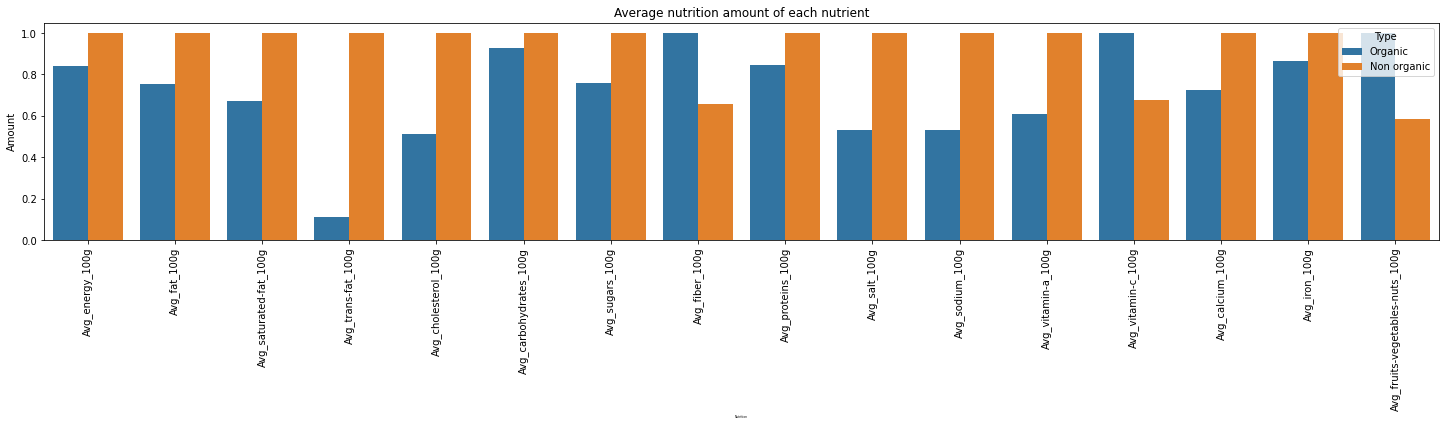

In [28]:
# Visualize the comparison of organic and non-organic food for the average amount of each nutrient
plt.figure(figsize=(25,4))
ax = sns.barplot(data=graph_df, x='Nutrition', y='Amount', hue='Type')
ax.set_xlabel('Nutrition', fontsize=3)
plt.xticks(rotation=90)
plt.title('Average nutrition amount of each nutrient')
plt.show()

From the results above, it seems only for fiber, vitamin-c, and fruits-vegetables-nuts, organic food has a higher average value. It is not defenite that organic food contains more amount of nutrition than non-organic food based on the dataset. 

The most obvious difference between organic and non-organic food occurs in trans-fat, which is considered to be the worst type of fats to eat ( [here is the reference](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/trans-fat/art-20046114#:~:text=Trans%20fat%20is%20considered%20the,the%20leading%20killer%20of%20adults.) ). It can be seen from the dataset that organic food contains much less amount of trans-fat than non-organic food.

We also need to mention that this observation may contain bias since we didn't consider the food categories and a different outlier range may also affect the results.

## 2.3 Additives and nutrition score/grade 

Many people care about if a food product contains additives since in commen sense, the more addtives the less heathy the food is. We studied the dataset to see what is the correlation between the number of additives in a food product and its nutrition score/grade. We also showed the distribution of number of additives on a world map.

### 2.3.1 Correlation between number of additives and nutrition scores

We want to know if there is a correlation between number of additives and nutrition scores and waht does it look like. 

In [29]:
# generate the num_additives and score pairs from the dataset 
# sort in ascending order of scores (good to bad)
sdf = spark.sql('''
SELECT CAST(additives_n AS INT) AS num_additives, AVG(nutriscore_score) AS score 
FROM df_2
GROUP BY 1
ORDER BY 1 ASC
''')
pdf = sdf.select('*').toPandas()
pdf

,num_additives,score
0,NaN,9.511414
1,0.0,5.947432
2,1.0,10.176917
3,2.0,11.088757
4,3.0,11.618314
5,4.0,11.741309
6,5.0,11.483851
7,6.0,11.664539
8,7.0,11.808649
9,8.0,12.693569


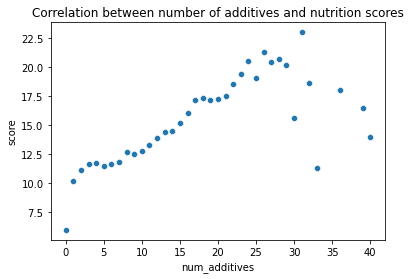

In [30]:
# visualize the resuts above
plt.figure()
ax = sns.scatterplot(data=pdf, x='num_additives', y='score')
plt.title('Correlation between number of additives and nutrition scores')
plt.show()


It is not surprise to see that there is a trend that the more number of additives added to the food product the higher score (lower grade) the food has.

### 2.3.2 Number of additives used per food item in different countries

We would like to see the overall additives used in different countries. We visualize it in a world map and show their average additives used as previous step.

In [31]:
sdf = spark.sql('''
SELECT countries_en,additives_n
FROM df_2
WHERE additives_n IS NOT NULL
''')
additives_countries_pdf = sdf.toPandas().astype({'additives_n':'int32'})
additives_countries_pdf.head()

,countries_en,additives_n
0,France,0
1,France,3
2,France,1
3,United States,0
4,France,2


In [32]:
additives_countries_pdf['country'] = additives_countries_pdf["countries_en"].str.split(",")
additives_countries_pdf = additives_countries_pdf.explode("country")
ave_num_add_df = additives_countries_pdf.dropna(subset=['additives_n']).groupby(['country'])['additives_n'].mean().reset_index()
print( ave_num_add_df.head() )

ave_num_add_max = ave_num_add_df['additives_n'].max()
ave_num_add_list = [[ave_num_add_df['country'][i],round(ave_num_add_df['additives_n'][i],1)] for i in range(len(ave_num_add_df))] #prepare data for visualization
print( ave_num_add_list[:3] )

          country  additives_n
0      Afganistan     0.000000
1     Afghanistan     2.346939
2  Afrique-du-sud     6.000000
3         Agypten     5.000000
4         Albania     1.107143
[['Afganistan', 0.0], ['Afghanistan', 2.3], ['Afrique-du-sud', 6.0]]


In [33]:
map_1 = Map(init_opts=opts.InitOpts(width='1400px', height='600px')) #create the map and set the size of the map
map_1.add('Average Number of Addtives', ave_num_add_list, maptype='world') #add world map
map_1.set_series_opts(label_opts=opts.LabelOpts(is_show=False)) #remove country names
map_1.set_global_opts( #set global configurations
 title_opts=opts.TitleOpts(title="Number of Additives Used Per Food Item in Different Country"),
 visualmap_opts=opts.VisualMapOpts( max_=ave_num_add_max,  is_piecewise=True),
 legend_opts=opts.LegendOpts(is_show=False), #show legend or not
 )
map_1.render_notebook() #show the map in the notebook directly
map_1.render('num_add.html')
IPython.display.HTML(filename='num_add.html')

## 2.4 Source of nutritions

We analyzed which food categories can provide certain nutrients, then we can make smart choices on food based on our needs of nutrients.

In [34]:
# explode the food group column
# we will use it as food category
from pyspark.sql.functions import split, col
df_3 = new_df.select('*', split(col("food_groups_en"),",").alias("food_groups_array"))
df_3.printSchema()
df_3.show()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable = true)
 |-- labels_en: string (nullabl

In [35]:
# explode the food group column to get the food category for each products. Some food products belong to multiple categories.
from pyspark.sql.functions import explode
df_3 = df_3.select('*', explode(df_3.food_groups_array).alias('food_group'))

In [36]:
# select nutrients that people like to take supplements for as target nutrients in our study.
# create a dictionary to store index and food category in order of the contained amount of each nutrient. 
# the smaller the index number, the higher amount of the nutrient contained in the category.
df_3.createOrReplaceTempView("df_3")
pdfs = {}
for s in ['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']:
    sdf = spark.sql('''
    SELECT food_group, AVG(`{}`) AS amount
    FROM df_3
    GROUP BY 1
    ORDER BY amount DESC
    '''.format(s))
    pdfs[s] = sdf.toPandas()

Just to note, since we didn't include the specific amounts of nutrients contained in each category into calculation and the index cannot fully represent how good or bad source a category is. The order below just shows a tendency but is not a complete study of which food categories are good nutrient sources.

In [37]:
# sum the index of each food category over all nutrients. 
# A smaller sum indicates the food category can provide more amount or more varieties of nutrients. 
counter_dict = {}
for s in ['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']:
# for s in ['energy_100g']:
    for index, row in pdfs[s].iterrows():
        # print(row['food_group'], row['amount'])
        food_group = row['food_group']
        if food_group in counter_dict:
            counter_dict[food_group] += index
        else:
            counter_dict[food_group] = index
dict(sorted(counter_dict.items(), key=lambda item: item[1]))

{'Breakfast cereals': 30,
 'Dried fruits': 81,
 'Milk and dairy products': 81,
 'Cheese': 87,
 'Pastries': 92,
 'Cereals and potatoes': 94,
 'Nuts': 97,
 'Cereals': 101,
 'Salty snacks': 102,
 'Salty and fatty products': 106,
 'Vegetables': 108,
 'Artificially sweetened beverages': 111,
 'Fruits and vegetables': 112,
 'Fish and seafood': 116,
 'One-dish meals': 120,
 'Composite foods': 121,
 'Fish‚ Meat‚ Eggs': 126,
 'Chocolate products': 128,
 'Sandwiches': 128,
 'Sugary snacks': 140,
 'Biscuits and cakes': 141,
 'Fatty fish': 142,
 'Milk and yogurt': 143,
 'Legumes': 144,
 'Fats': 150,
 'Beverages': 150,
 'Potatoes': 151,
 'Fruit juices': 159,
 'Sweets': 160,
 'Unsweetened beverages': 162,
 'Pizza pies and quiches': 167,
 'Dairy desserts': 167,
 'Bread': 170,
 'Fruits': 175,
 'Appetizers': 175,
 'Fats and sauces': 180,
 'Sweetened beverages': 183,
 'Meat other than poultry': 188,
 'Processed meat': 191,
 'Meat': 193,
 'Plant-based milk substitutes': 195,
 'Dressings and sauces': 200,

It can be seem from the results above, breakfast cereals has the best score. This maybe because they were made to be a good source of nutriens, so more varieties of nutrients were added to reach that purpose. Other categories, such as meat, eggs, fruits, they are good sources of some specific nutrients but may not contain as good variety of nutrients as processed food. It is also worth mentioned that milk and dairy products, dried fruits, and cheese also have a high rank. It would be a good choice to add more of these categories to our daily diet.

## 2.5 High fat foods and countries

Is it true that food in the US is less healthy due to a common stereotype that US food products contain more fats as compared to European food products?

Lets explore this question 

In [38]:
new_df.createOrReplaceTempView("sdf")

sql_q = spark.sql('''
select countries_en, 
product_name,
cast(fat_100g as float) fat_100g, 
cast(`saturated-fat_100g` as float) `saturated-fat_100g`,
cast(`trans-fat_100g` as float) as `trans-fat_100g`,
 ingredients_text, 
cast( `cholesterol_100g` as float) as `cholesterol_100g`, 
cast( `carbohydrates_100g` as float) as `carbohydrates_100g`,
cast( `sugars_100g` as float) as `sugars_100g`, 
cast( `energy_100g` as float) as `energy_100g`
from sdf
where countries_en in ('United States', 'France', 'Italy', 'Germany', 'Belgium', 'Spain', 'Denmark', 'Switzerland')
''')
df = sql_q.select('*').toPandas()

In [39]:
print( df.shape )
df.head()

(2074985, 10)


,countries_en,product_name,fat_100g,saturated-fat_100g,trans-fat_100g,ingredients_text,cholesterol_100g,carbohydrates_100g,sugars_100g,energy_100g
0,France,jeunes pousses,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,Germany,Andrè,2.0,2.00,NaN,None,NaN,65.000000,12.6,690.0
2,Spain,L.casei,1.4,0.90,NaN,"Leche semidesnatada, azucar 6.9%, leche desnat...",NaN,9.800000,9.8,NaN
3,France,Skyr,0.2,0.10,NaN,None,NaN,3.900000,3.9,238.0
4,France,Vitória crackers,7.0,3.08,NaN,None,NaN,70.099998,15.0,1569.0


In [40]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

Text(0.5, 1.0, 'Missing percentage in each column')

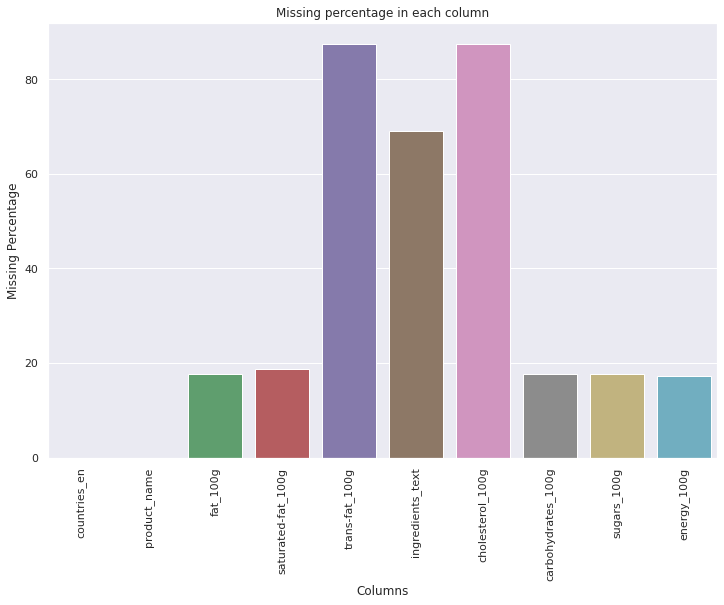

In [41]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(data=missing_value_df, x="column_name", y="percent_missing")
ax.set(xlabel = "Columns", ylabel = "Missing Percentage")
ax.tick_params(axis='x', rotation=90)
ax.set_title('Missing percentage in each column')

In [42]:
df.dtypes

countries_en           object
product_name           object
fat_100g              float32
saturated-fat_100g    float32
trans-fat_100g        float32
ingredients_text       object
cholesterol_100g      float32
carbohydrates_100g    float32
sugars_100g           float32
energy_100g           float32
dtype: object

Text(0.5, 1.0, 'Fat amount distribution in different countries')

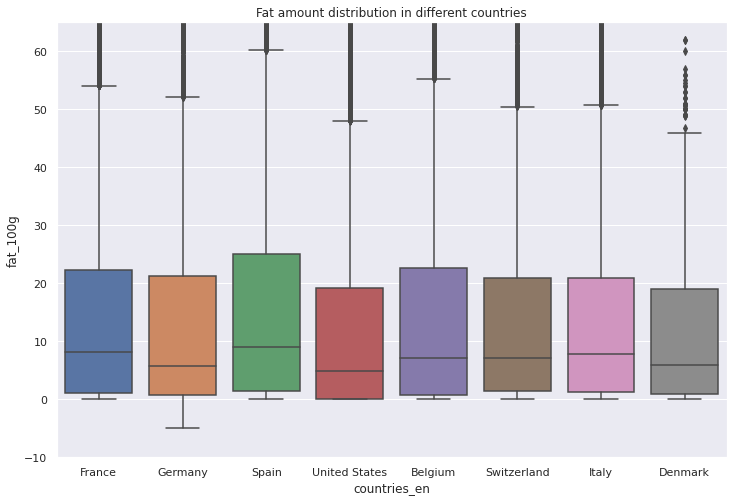

In [43]:
# Using boxplot to visulaize the distribution of fat_100g by country
ax = sns.boxplot(x='countries_en', y='fat_100g', data=df)
ax.set(ylim=(-10, 65))
ax.set_title('Fat amount distribution in different countries')

This is an interesting trend that US has one of the lowest median fat level per 100gms of food and US is still known as one of the most obese nations. While doing some literature search, I found that this trend has been already documented. For example this research mentioned this trend(Wansink, B., & Chandon, P. (2006). Can “Low-Fat” Nutrition Labels Lead to Obesity? Journal of Marketing Research, 43(4), 605–617. https://doi.org/10.1509/jmkr.43.4.605) .

Text(0.5, 1.0, 'Saturated-fat amount distribution in different countries')

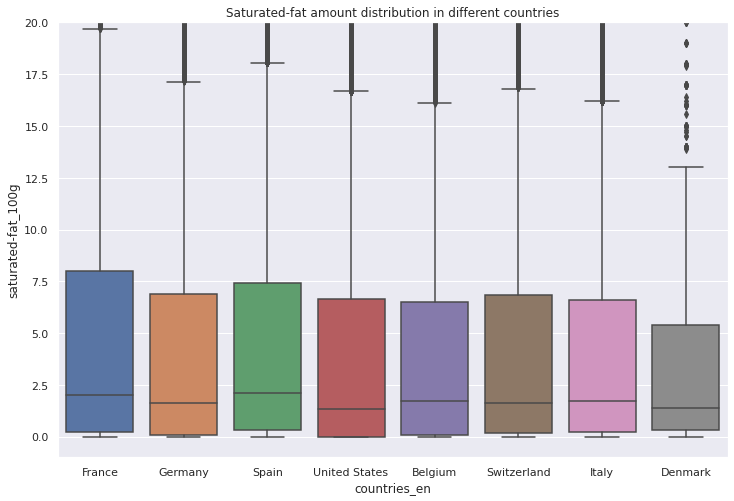

In [44]:
# Using boxplot to visulaize the distribution of saturated-fat_100g by country
ax = sns.boxplot(x='countries_en', y='saturated-fat_100g', data=df)
ax.set(ylim=(-1, 20))
ax.set_title('Saturated-fat amount distribution in different countries')

For saturated-fat, the US is still one of the countries that have low level of median saturated-fat. 

## 2.6 Top 10 Countries with almond containing products

While discussion with some families, it was interesting to learn abount almond industry in the USA. I was curious to explore what proportion of US products contain almonds and how does it compare with other European countries.

Caution: Ingredient text is highly missing (~70%) in data so please interpret the results carefully.

In [45]:
df['has_almonds'] = df.ingredients_text.str.contains('almond', case = False)

Text(0.5, 1.0, 'Percentage of Products Contain Almonds in different countries')

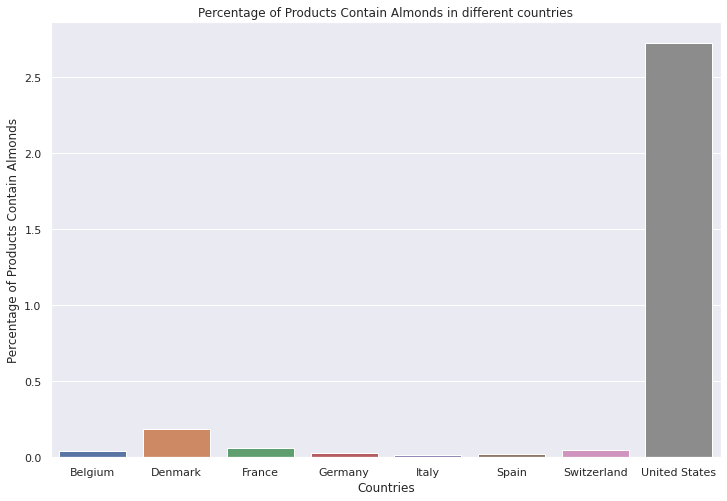

In [46]:
df['has_almonds'].fillna(False, inplace=True)
n_almonds = pd.DataFrame({'n_almonds' : df.groupby('countries_en')['has_almonds'].sum(), 'total' : df.groupby('countries_en')['has_almonds'].count()}).reset_index()
n_almonds['pencentage_almonds'] = n_almonds['n_almonds']*100/n_almonds['total']
ax = sns.barplot(data=n_almonds, x="countries_en", y="pencentage_almonds")
ax.set(xlabel = "Countries", ylabel = "Percentage of Products Contain Almonds")
ax.set_title('Percentage of Products Contain Almonds in different countries')

Given the high missingness, I wont try to over-interpret the results. However, if we assume that missingness is totally random, we can state that US has highest proportion of products with almonds. 

Interpretation of US data: About 2.75% of all products in this database in USA contain almonds.

*Please note that the y axis is in percentage. So there is no need to normalize the data*. 

## 2.7 Clustering by some nutrients that may cause obesity

Next we will try to find food clusters based on energy (calories), fats, carbohydrates, cholesterol, and sugars. I selected these variables because the general percention is that these variables are most closely associated obesity.

However, we noticed that trans fat and cholesterol variables are highly missing (>80) so we will not be able to use these variables.

Missing data handling

In [47]:
km_df = df[['fat_100g', 
            'saturated-fat_100g', 
            'carbohydrates_100g', 
            'sugars_100g',
            'energy_100g']]

In [48]:
km_df.shape

(2074985, 5)

In [49]:
percent_missing = km_df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': km_df.columns,
                                 'percent_missing': percent_missing})

In [50]:
missing_value_df

,column_name,percent_missing
fat_100g,fat_100g,17.635742
saturated-fat_100g,saturated-fat_100g,18.810353
carbohydrates_100g,carbohydrates_100g,17.632995
sugars_100g,sugars_100g,17.691260
energy_100g,energy_100g,17.232462


Missingness is around 20% in remaining variables

Lets remove records with missing values


In [51]:
km_df.dropna(inplace = True)
km_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,energy_100g
1,2.0,2.00,65.000000,12.60,690.0
3,0.2,0.10,3.900000,3.90,238.0
4,7.0,3.08,70.099998,15.00,1569.0
7,11.0,3.90,5.700000,0.05,812.0
8,15.1,6.10,2.600000,1.00,3661.0


We lost ~20% of data which is manageable.

Let see if we have any highly correlated variables

In [52]:
km_df.corr()

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,energy_100g
fat_100g,1.000000,0.413452,4.943116e-01,0.494284,5.485886e-03
saturated-fat_100g,0.413452,1.000000,6.219806e-01,0.620926,7.064182e-04
carbohydrates_100g,0.494312,0.621981,1.000000e+00,0.999998,8.932304e-07
sugars_100g,0.494284,0.620926,9.999982e-01,1.000000,3.028139e-06
energy_100g,0.005486,0.000706,8.932304e-07,0.000003,1.000000e+00


In [53]:
km_df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-53-4cec16fe96c6>:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  km_df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,energy_100g
fat_100g,1.00,0.41,0.49,0.49,0.01
saturated-fat_100g,0.41,1.00,0.62,0.62,0.00
carbohydrates_100g,0.49,0.62,1.00,1.00,0.00
sugars_100g,0.49,0.62,1.00,1.00,0.00
energy_100g,0.01,0.00,0.00,0.00,1.00


I see carbohydrates and sugars are highly correlated, which makes sense. We can drop one of the these variable.

In [54]:
km_df.drop('carbohydrates_100g', axis = 1, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Removing Outliers based on zscore < 3

In [55]:
import numpy as np
from scipy import stats
km_df = km_df[(np.abs(stats.zscore(km_df)) < 3).all(axis=1)]

KMeans is not a scale invariant model so we need to standardize our dataset

In [56]:
from sklearn.preprocessing import scale
X_scaled = scale(km_df)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


First lets find out how many clusters best explain the data.

In [57]:
from sklearn.cluster import KMeans
ssd = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(X_scaled)
    ssd.append(kmeans.inertia_)

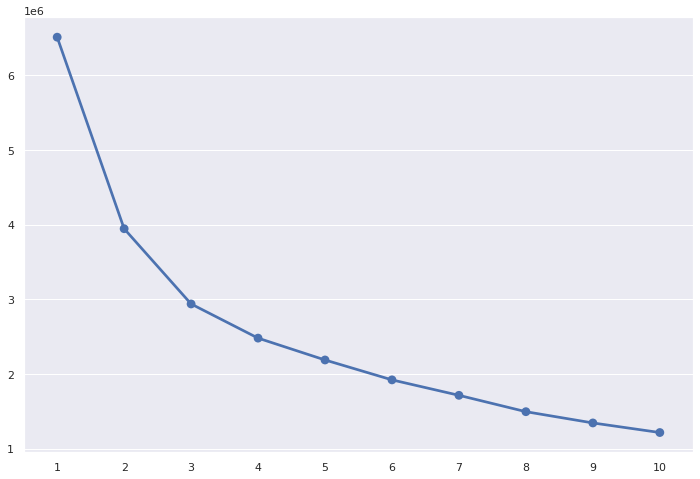

In [58]:
sns.pointplot(y = ssd, x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Based on this plot and using the Elbow Method the best number of clusters is anywhere from 4 to 8. I am selecting 6 for this usecase

In [59]:
kmeans = KMeans(n_clusters = 6, random_state = 1).fit(X_scaled)

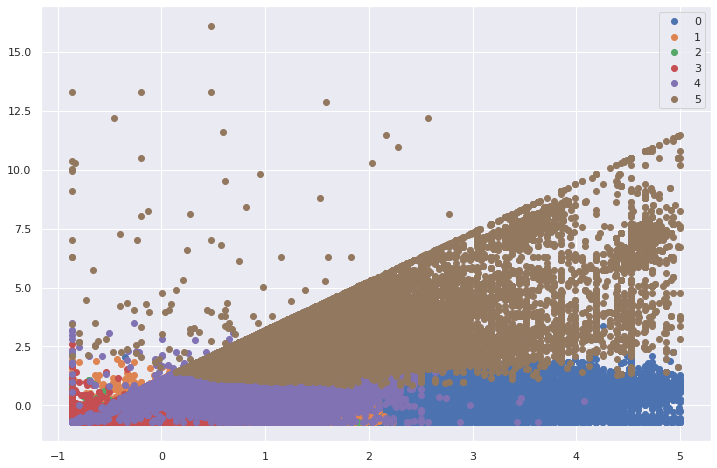

In [60]:
label = kmeans.fit_predict(X_scaled)
 
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X_scaled[label == i , 0] , X_scaled[label == i , 1] , label = i)
plt.legend()
plt.show()

Lets try to find out what variables contributed to which cluster the most.

In [61]:
km_df['cluster'] = label

In [62]:
km_df.cluster.value_counts()

3    603422
1    489936
4    154089
2    137004
5    123603
0    119332
Name: cluster, dtype: int64

In [63]:
km_df.groupby('cluster').mean()

,fat_100g,saturated-fat_100g,sugars_100g,energy_100g
cluster,,,,
0,41.571224,6.740782,4.511858,2268.725830
1,11.642339,3.725171,6.309640,1298.965820
2,2.752819,0.932829,59.292076,1362.202515
3,2.423542,0.749725,4.789049,350.427826
4,25.774593,12.825111,38.262527,2013.232422
5,35.898666,22.294584,5.127418,1784.844604


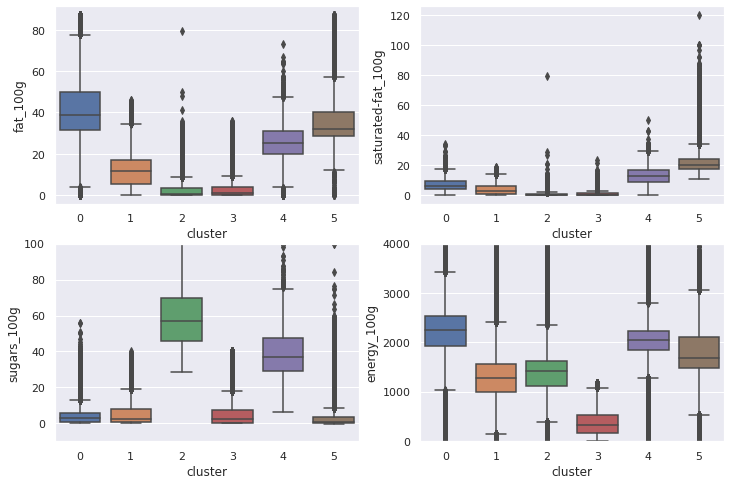

In [64]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
index = 0
col = ['fat_100g', 
            'saturated-fat_100g', 
            'sugars_100g',
            'energy_100g']
for axis in range(0,4):
  i, j = divmod(index, 2)
  ax = sns.boxplot(x='cluster', y=col[index], data=km_df, ax = axes[i, j])
  if index == 3:
    ax.set(ylim=(-10, 4000))
  if index == 2:
    ax.set(ylim=(-10, 100))
  index = index+1
plt.show()

Conclusion : Interestingly, cluster 0,4,5 are high saturated fat and overall fat food products. However, cluster 2 is high in energy in sugars. 

**It looks like cluster 3 foods are low fat, low calorie, and low sugars food.** 

So we are able to find good clusters from this data.

Lets look at some examples of foods in cluster 3.

In [65]:
df.iloc[km_df.loc[km_df.cluster == 3, :].index].head(10)

,countries_en,product_name,fat_100g,saturated-fat_100g,trans-fat_100g,ingredients_text,cholesterol_100g,carbohydrates_100g,sugars_100g,energy_100g,has_almonds
1,Germany,Andrè,2.0,2.0,NaN,None,NaN,65.000000,12.600000,690.0,False
3,France,Skyr,0.2,0.1,NaN,None,NaN,3.900000,3.900000,238.0,False
11,France,Sauce Sweety chili 0%,0.0,0.0,NaN,None,NaN,4.800000,0.400000,88.0,False
12,France,Mini coco,3.0,1.0,NaN,None,NaN,10.000000,3.000000,251.0,False
18,France,Pur jus de pomme,0.0,0.0,NaN,None,NaN,15.500000,15.500000,264.0,False
20,France,Salade de carottes râpées,0.3,0.1,NaN,None,NaN,5.300000,3.900000,134.0,False
21,France,Fromage blanc aux myrtilles,4.9,3.1,NaN,None,NaN,16.299999,16.299999,540.0,False
23,Spain,Iogurt de cabra,4.3,3.0,NaN,None,NaN,4.300000,1.600000,305.0,False
24,France,Baguette parisien,3.3,2.1,NaN,None,NaN,38.400002,1.800000,929.0,False
27,France,Solène céréales poulet,5.9,0.5,NaN,"antioxydant : érythorbate de sodium, colorant ...",NaN,30.299999,1.700000,916.0,False


# 3 Feature Engineering 

By learning about how nutriscore was calculated, we know there are some features count as positive and others are negative. Also, there are some special rules, such as beverage and solid food were calculated in different ways. For the beverage example, we set a column with boolean velue to distinguish beverage from solid food.

In order to get better predition accuracy, we refered to the following resources to decide which features to add to our models:

https://www.frontiersin.org/articles/10.3389/fnut.2022.974003/full

https://get.apicbase.com/nutri-score-science-based-nutritional-value-labelling-system/


In [71]:
df = spark.read.option("encoding", "UTF-8").option("delimiter", "\t").option("header", "True").csv(path)
df = df.na.drop(subset=["product_name"])


In [72]:
# drop colums that contain null in 'nutrisocre_score' or 'nutriscore_grade' columns.
df = df.filter(df.nutriscore_grade.isNotNull() | df.nutriscore_score.isNotNull())

In [73]:
# drop colums that are not needed in the modeling
# kept columns that may affect the nutrition score based on the reference documents and our understanding
cols_to_drop = [
    'url',
    'creator',
    'created_t',
    'created_datetime',
    'last_modified_t',
    'last_modified_datetime',
    'abbreviated_product_name',
    'generic_name',
    'quantity',
    'packaging',
    'packaging_tags',
    'packaging_en',
    'packaging_text',
    'brands',
    'brands_tags',
    'categories',
    'categories_en',
    'origins',
    'origins_tags',
    'origins_en',
    'manufacturing_places',
    'manufacturing_places_tags',
    'labels',
    'labels_tags',
    'emb_codes',
    'emb_codes_tags',
    'first_packaging_code_geo',
    'cities',
    'cities_tags',
    'purchase_places',
    'stores',
    'countries',
    'countries_tags',
    'ingredients_text',
    'ingredients_tags',
    'ingredients_analysis_tags',
    'allergens',
    'allergens_en',
    'traces',
    'traces_tags',
    'traces_en',
    'serving_size',
    'serving_quantity',
    'no_nutriments',
    'additives',
    'additives_tags',
    'additives_en',
    'nova_group',
    'pnns_groups_1',
    'pnns_groups_2',
    'food_groups',
    'food_groups_tags',
    'states',
    'states_tags',
    'states_en',
    'brand_owner',
    'ecoscore_grade',
    'ecoscore_score',
    'nutrient_levels_tags',
    'product_quantity',
    'owner',
    'data_quality_errors_tags',
    'unique_scans_n',
    'popularity_tags',
    'completeness',
    'last_image_t',
    'last_image_datetime',
    'main_category',
    'image_url',
    'image_small_url',
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url',
    'carbon-footprint_100g',
    'carbon-footprint-from-meat-or-fish_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g',
]
df_train = df.drop(*cols_to_drop)



In [74]:
# Save the training data into a temp file and read from it to save memory
import pyarrow.parquet as pq
df_train.repartition(1).write.mode('overwrite').parquet('tmp/data')

In [75]:
df_train = pd.read_parquet('tmp/data')
df_train

,code,product_name,categories_tags,labels_en,countries_en,additives_n,nutriscore_score,nutriscore_grade,food_groups_en,main_category_en,...,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000026772226,Skyr,"en:dairies,en:desserts,en:fermented-foods,en:f...",None,France,None,-5,a,"Milk and dairy products,Dairy desserts",Cream cheeses,...,None,None,None,None,None,None,None,None,None,None
1,0000000000100,moutarde au moût de raisin,"en:condiments,en:sauces,en:mustards,en:groceries",fr:delois-france,France,0,18,d,"Fats and sauces,Dressings and sauces",Groceries,...,None,None,None,None,None,None,None,None,None,None
2,000000000080,Pur jus de pomme,"en:plant-based-foods-and-beverages,en:beverage...",None,France,None,9,d,"Beverages,Fruit juices",Squeezed apple juices,...,None,None,None,None,None,None,None,None,None,None
3,0000000000949,Salade de carottes râpées,"en:plant-based-foods-and-beverages,en:plant-ba...",None,France,None,1,b,"Composite foods,One-dish meals",Seasoned grated carrots,...,None,None,None,None,None,None,None,None,None,None
4,0000000001281,Tarte noix de coco,"en:sweet-pies,en:pies,en:coconut-pies",None,France,None,14,d,"Composite foods,Pizza pies and quiches",Coconut pies,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833365,9999991149090,Riz parfumé,"en:plant-based-foods-and-beverages,en:plant-ba...",None,France,None,0,b,"Cereals and potatoes,Cereals",Aromatic rices,...,None,None,None,None,None,None,None,None,None,None
833366,9999999004360,Minis beignets,"en:snacks,en:sweet-snacks,en:sweet-fritters",None,France,None,15,d,None,Sweet Fritters,...,None,None,None,None,None,None,None,None,None,None
833367,9999999175305,Erdbeerkuchen 1019g tiefgefroren,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...",Made in Germany,Germany,2,12,d,"Sugary snacks,Biscuits and cakes",de:tiefkühl-kuchen,...,None,None,None,None,None,None,None,None,None,None
833368,99999995,Steak haché 5%,"en:meats,en:beef,en:meat-patties,en:boeuf,en:s...",None,France,0,-2,a,"Fish‚ Meat‚ Eggs,Meat,Meat other than poultry",Viandes,...,None,None,None,None,None,None,None,None,None,None


In [76]:
# set the type of all non-string columns to float
string_columns = ['code', 'product_name', 'categories_tags', 'countries_en', 'nutriscore_grade', 'food_groups_en', 'main_category_en', 'labels_en'] 
float_columns = list(set(df_train.columns) - set(string_columns))
for column in float_columns:
    df_train[column] = df_train[column].astype('float')

More feature engineering related contents are combined with modeling in the session below.

# 4 Modeling 

We tried to use linear regression and decision tree to train our models and see which model can give us more accurate predictions.

In [77]:
# fill the emtpy numeric data with 0
import statsmodels.api as sm

X = df_train[['salt_100g', 'sodium_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'fiber_100g', 'carbohydrates_100g', 'additives_n']]
X = X.fillna(0)
y = df_train['nutriscore_score']

In [78]:
# remove outlier for the energy column, plot distribution
def remove_outlier(X):
    X['energy_100g'] = X['energy_100g'].clip(upper=4000)
    for c in X.columns:
        if 'energy' not in c:
            X[c] = X[c].clip(upper=100)
remove_outlier(X)

In [79]:
# check the distribution of some features
# Show X's content
X

,salt_100g,sodium_100g,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,fiber_100g,carbohydrates_100g,additives_n
0,0.09,0.036,238.0,0.2,0.1,3.9,10.0,0.0,0.0,3.9,0.0
1,4.60,1.840,936.0,8.2,2.2,22.0,5.1,0.0,0.0,29.0,0.0
2,0.00,0.000,264.0,0.0,0.0,15.5,0.2,0.0,0.0,15.5,0.0
3,0.42,0.168,134.0,0.3,0.1,3.9,0.9,0.0,0.0,5.3,0.0
4,0.10,0.040,1594.0,22.0,15.5,21.9,4.6,0.0,4.4,27.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...
833365,0.00,0.000,1469.0,0.5,0.0,0.0,7.0,0.0,0.0,80.0,0.0
833366,1.10,0.440,1393.0,20.2,6.0,10.4,7.4,0.0,0.0,30.9,0.0
833367,0.28,0.112,925.0,7.6,4.8,24.0,2.6,12.0,0.0,35.0,2.0
833368,0.18,0.072,548.0,5.0,2.3,0.0,21.5,0.0,0.0,0.0,0.0


In [80]:
def train_model(x, y):
    x_train_with_constant = sm.add_constant(x)
    model = sm.OLS(y, x_train_with_constant)
    model = model.fit()
    y_pred = model.predict(x_train_with_constant)
    print(np.round(np.sqrt(np.sum(((np.array(y_pred)-np.array(y))**2))/len(y_pred)),2))
    return model
model = train_model(X, y)
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


5.35


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       nutriscore_score   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 1.234e+05
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:01:25   Log-Likelihood:            -2.5797e+06
No. Observations:              833370   AIC:                         5.160e+06
Df Residuals:                  833358   BIC:                         5.160e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     1.5715      0.013    123.910      0.000       1.547       1.596
salt_100g                                                 0.6900      0.004    186.672      0.000       0.683       0.697
sodium_100g                                              -0.6364      0.006    -99.466      0.000      -0.649      -0.624
energy_100g                                               0.0031   2.48e-05    123.529      0.000       0.003       0.003
fat_100g                                                  0.0110      0.001     10.897      0.000       0.009       0.013
saturated-fat_100g                                        0.3606      0.001    348.770      0.000       0.359       0.363
sugars_100g                                               0.1991      0.000    445.059      0.000       0.198       0.200
proteins_100g                                             0.0466      0.001     59.666      0.000       0.045       0.048
fruits-vegetables-nuts-estimate-from-ingredients_100g    -0.0593      0.000   -183.184      0.000      -0.060      -0.059
fiber_100g                                               -0.3963      0.002   -244.072      0.000      -0.399      -0.393
carbohydrates_100g                                       -0.0333      0.001    -66.223      0.000      -0.034      -0.032
additives_n                                               0.3843      0.002    166.228      0.000       0.380       0.389
==============================================================================
Omnibus:                    31443.069   Durbin-Watson:                   1.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82407.041
Skew:                          -0.170   Prob(JB):                         0.00
Kurtosis:                       4.503   Cond. No.                     3.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
# add boolean columns to categorize dataset
# these categoies have a different algorithm when calculating nutrition scores
 
X = df_train[['salt_100g', 'sodium_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'fiber_100g', 'carbohydrates_100g', 'additives_n', 'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts_100g']]
y = df_train['nutriscore_score']

X['is_beverage'] = 0
X['is_oil'] = 0
X['contains_fruit'] = 0
X['is_fats'] = 0
X['is_water'] = 0


X = X.fillna(0)
X.loc[df_train['categories_tags'].str.contains('en:beverages', na=False), 'is_beverage'] = 1
X.loc[df_train['categories_tags'].str.contains('oil', na=False), 'is_oil'] = 1
X.loc[df_train['categories_tags'].str.contains('fruit', na=False), 'contains_fruit'] = 1
X.loc[df_train['categories_tags'].str.contains('en:fats', na=False), 'is_fats'] = 1
X.loc[df_train['categories_tags'].str.contains('en:spring-waters', na=False), 'is_water'] = 1



<ipython-input-81-f0601ad46c3d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_beverage'] = 0
<ipython-input-81-f0601ad46c3d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_oil'] = 0
<ipython-input-81-f0601ad46c3d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [82]:
remove_outlier(X)
model = train_model(X, y)
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


4.74


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       nutriscore_score   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                 1.087e+05
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:01:30   Log-Likelihood:            -2.4790e+06
No. Observations:              833370   AIC:                         4.958e+06
Df Residuals:                  833351   BIC:                         4.958e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.5881      0.013     43.774      0.000       0.562       0.614
salt_100g                                                 0.6931      0.003    210.941      0.000       0.687       0.700
sodium_100g                                              -0.6401      0.006   -112.776      0.000      -0.651      -0.629
energy_100g                                               0.0036   2.21e-05    162.098      0.000       0.004       0.004
fat_100g                                                  0.1020      0.001    109.785      0.000       0.100       0.104
saturated-fat_100g                                        0.3247      0.001    344.580      0.000       0.323       0.327
sugars_100g                                               0.1902      0.000    473.717      0.000       0.189       0.191
proteins_100g                                             0.0087      0.001     11.910      0.000       0.007       0.010
fruits-vegetables-nuts-estimate-from-ingredients_100g    -0.0525      0.000   -172.247      0.000      -0.053      -0.052
fiber_100g                                               -0.4137      0.001   -286.458      0.000      -0.417      -0.411
carbohydrates_100g                                       -0.0347      0.000    -77.183      0.000      -0.036      -0.034
additives_n                                               0.3334      0.002    161.204      0.000       0.329       0.337
fruits-vegetables-nuts-estimate_100g                      0.0026      0.001      3.111      0.002       0.001       0.004
fruits-vegetables-nuts_100g                              -0.0126      0.001    -13.685      0.000      -0.014      -0.011
is_beverage                                               5.9458      0.022    273.405      0.000       5.903       5.988
is_oil                                                   -3.7892      0.043    -88.889      0.000      -3.873      -3.706
contains_fruit                                           -1.5934      0.019    -85.603      0.000      -1.630      -1.557
is_fats                                                 -13.9260      0.048   -288.343      0.000     -14.021     -13.831
is_water                                                 -6.4281      0.079    -81.315      0.000      -6.583      -6.273
==============================================================================
Omnibus:                    42010.732   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           144961.300
Skew:                          -0.149   Prob(JB):                         0.00
Kurtosis:                       5.021   Cond. No.                     2.16e+04
====

In [83]:
# add is_organic feature into the model
 
X = df_train[['salt_100g', 'sodium_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'fiber_100g', 'carbohydrates_100g', 'additives_n', 'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts_100g']]
y = df_train['nutriscore_score']

X['is_beverage'] = 0
X['is_oil'] = 0
X['contains_fruit'] = 0
X['is_fats'] = 0
X['is_water'] = 0
X['is_organic'] = 0

X = X.fillna(0)
X.loc[df_train['categories_tags'].str.contains('en:beverages', na=False), 'is_beverage'] = 1
X.loc[df_train['categories_tags'].str.contains('oil', na=False), 'is_oil'] = 1
X.loc[df_train['categories_tags'].str.contains('fruit', na=False), 'contains_fruit'] = 1
X.loc[df_train['categories_tags'].str.contains('en:fats', na=False), 'is_fats'] = 1
X.loc[df_train['categories_tags'].str.contains('en:spring-waters', na=False), 'is_water'] = 1
X.loc[df_train['labels_en'] == 'Organic', 'is_organic'] = 1


remove_outlier(X)
model = train_model(X, y)
model.summary()

<ipython-input-83-7d87e0a858fa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_beverage'] = 0
<ipython-input-83-7d87e0a858fa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_oil'] = 0
<ipython-input-83-7d87e0a858fa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

4.74


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       nutriscore_score   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                 1.032e+05
Date:                Sun, 18 Dec 2022   Prob (F-statistic):               0.00
Time:                        02:01:36   Log-Likelihood:            -2.4785e+06
No. Observations:              833370   AIC:                         4.957e+06
Df Residuals:                  833350   BIC:                         4.957e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.6234      0.013     46.269      0.000       0.597       0.650
salt_100g                                                 0.6920      0.003    210.736      0.000       0.686       0.698
sodium_100g                                              -0.6392      0.006   -112.687      0.000      -0.650      -0.628
energy_100g                                               0.0036   2.21e-05    161.978      0.000       0.004       0.004
fat_100g                                                  0.1019      0.001    109.733      0.000       0.100       0.104
saturated-fat_100g                                        0.3248      0.001    344.808      0.000       0.323       0.327
sugars_100g                                               0.1902      0.000    473.876      0.000       0.189       0.191
proteins_100g                                             0.0083      0.001     11.357      0.000       0.007       0.010
fruits-vegetables-nuts-estimate-from-ingredients_100g    -0.0523      0.000   -171.660      0.000      -0.053      -0.052
fiber_100g                                               -0.4114      0.001   -284.682      0.000      -0.414      -0.409
carbohydrates_100g                                       -0.0346      0.000    -76.995      0.000      -0.035      -0.034
additives_n                                               0.3294      0.002    159.047      0.000       0.325       0.333
fruits-vegetables-nuts-estimate_100g                      0.0025      0.001      3.026      0.002       0.001       0.004
fruits-vegetables-nuts_100g                              -0.0131      0.001    -14.233      0.000      -0.015      -0.011
is_beverage                                               5.9591      0.022    274.130      0.000       5.916       6.002
is_oil                                                   -3.7916      0.043    -88.999      0.000      -3.875      -3.708
contains_fruit                                           -1.5909      0.019    -85.523      0.000      -1.627      -1.554
is_fats                                                 -13.8875      0.048   -287.625      0.000     -13.982     -13.793
is_water                                                 -6.4753      0.079    -81.946      0.000      -6.630      -6.320
is_organic                                               -1.0230      0.032    -31.632      0.000      -1.086      -0.960
==============================================================================
Omnibus:                    41652.283   Durbin-Watson:                   1.187
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           142535.111
Skew:                          -0.150   

## 4.1 Linear regression

In [84]:
from sklearn.model_selection import train_test_split

# TO-DO: Conduct 80/20 train-test split with random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.20)

# Apply normalization, StandardScaler doesn't work
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [85]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)

from sklearn.metrics import mean_squared_error
import math
y_pred = reg.predict(x_train)
print(mean_squared_error(y_train, y_pred))
print(math.sqrt(mean_squared_error(y_train, y_pred)))

22.448569279101058
4.7379921147149515


In [86]:
y_pred = reg.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

22.33514598671572
4.7260074044287865


## 4.2 Decision tree

In [87]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=10)
clf = clf.fit(x_train, y_train)

In [88]:
y_pred = clf.predict(x_train)
print('train mse', mean_squared_error(y_train, y_pred))
print('train rmse', math.sqrt(mean_squared_error(y_train, y_pred)))

train mse 1.7802163835821783
train rmse 1.3342474971241949


In [89]:
y_pred = clf.predict(x_test)
print('test mse', mean_squared_error(y_test, y_pred))
print('test rmse', math.sqrt(mean_squared_error(y_test, y_pred)))

test mse 2.1905111469897114
test rmse 1.4800375491823548


Based on the description of how the nitrition scores were calculated, we knew there are some columns were applied by multiple algorithms based on their different ranges of values. We added features with boolen values to reflect the categories. 
The linear regression showed a high MSE, so it did not get a satisfied accuracy since it is hard to reflect the categorical algorithms linearly. We also applied decision tree for regression and it showed a better accuracy.

# 5 Recommend a Better Alternative

Suppose a customer want to buy a product "'Tomato ketchup'".

Can you recommend a better food item 
*   in the same food category
*   that has the similar nutrients such as carbohydrate,vitamin...,
*   but better (smaller) nutriscore ?



In [90]:
# Data Preprocessing
# columns to keeps
columns_keep = [
    "product_name",
    "food_groups_en",
    "nutriscore_score",
    "serving_quantity",
    "product_quantity",
    "energy-kcal_100g",
    "fat_100g",
    "saturated-fat_100g",
    "trans-fat_100g",
    "cholesterol_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g",
    "sodium_100g",
    "vitamin-a_100g",
    "vitamin-c_100g",
    "calcium_100g",
    "iron_100g",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g",
    "additives_n"
] 
# df_3 = new_df.select('*', split(col("food_groups_en"),",").alias("food_groups_array"))
new_df_2 = new_df.select(columns_keep)

In [91]:
# Since there are multiple food item with the same product name, select the Highest one
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

# all rows with the same product name will be merged into one row
w2 = Window.partitionBy("product_name").orderBy(col("nutriscore_score").desc())
new_df_2 = new_df_2.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row")

# change data type
new_df_2 = new_df_2.withColumn("nutriscore_score",col("nutriscore_score").cast("float"))
new_df_2 = new_df_2.withColumn("serving_quantity",col("serving_quantity").cast("float"))
new_df_2 = new_df_2.withColumn("product_quantity",col("product_quantity").cast("float"))
new_df_2 = new_df_2.withColumn("energy-kcal_100g",col("energy-kcal_100g").cast("float"))
new_df_2 = new_df_2.withColumn("fat_100g",col("fat_100g").cast("float"))
new_df_2 = new_df_2.withColumn("saturated-fat_100g",col("saturated-fat_100g").cast("float"))
new_df_2 = new_df_2.withColumn("trans-fat_100g",col("trans-fat_100g").cast("float"))
new_df_2 = new_df_2.withColumn("cholesterol_100g",col("cholesterol_100g").cast("float"))
new_df_2 = new_df_2.withColumn("carbohydrates_100g",col("carbohydrates_100g").cast("float"))
new_df_2 = new_df_2.withColumn("sugars_100g",col("sugars_100g").cast("float"))
new_df_2 = new_df_2.withColumn("fiber_100g",col("fiber_100g").cast("float"))
new_df_2 = new_df_2.withColumn("proteins_100g",col("proteins_100g").cast("float"))
new_df_2 = new_df_2.withColumn("salt_100g",col("salt_100g").cast("float"))
new_df_2 = new_df_2.withColumn("sodium_100g",col("sodium_100g").cast("float"))
new_df_2 = new_df_2.withColumn("vitamin-a_100g",col("vitamin-a_100g").cast("float"))
new_df_2 = new_df_2.withColumn("vitamin-c_100g",col("vitamin-c_100g").cast("float"))
new_df_2 = new_df_2.withColumn("calcium_100g",col("calcium_100g").cast("float"))
new_df_2 = new_df_2.withColumn("iron_100g",col("iron_100g").cast("float"))
new_df_2 = new_df_2.withColumn("fruits-vegetables-nuts-estimate-from-ingredients_100g",col("fruits-vegetables-nuts-estimate-from-ingredients_100g").cast("float"))
new_df_2 = new_df_2.withColumn("additives_n",col("additives_n").cast("float"))
#new_df_2.printSchema()

# removing row that missing values for nutriscore_score
new_df_2 = new_df_2.filter(new_df_2.nutriscore_score.isNotNull())

# fill missing with 0
new_df_2 = new_df_2.na.fill(value=0,subset=columns_keep[2:])

new_df_2.printSchema()

root
 |-- product_name: string (nullable = true)
 |-- food_groups_en: string (nullable = true)
 |-- nutriscore_score: float (nullable = false)
 |-- serving_quantity: float (nullable = false)
 |-- product_quantity: float (nullable = false)
 |-- energy-kcal_100g: float (nullable = false)
 |-- fat_100g: float (nullable = false)
 |-- saturated-fat_100g: float (nullable = false)
 |-- trans-fat_100g: float (nullable = false)
 |-- cholesterol_100g: float (nullable = false)
 |-- carbohydrates_100g: float (nullable = false)
 |-- sugars_100g: float (nullable = false)
 |-- fiber_100g: float (nullable = false)
 |-- proteins_100g: float (nullable = false)
 |-- salt_100g: float (nullable = false)
 |-- sodium_100g: float (nullable = false)
 |-- vitamin-a_100g: float (nullable = false)
 |-- vitamin-c_100g: float (nullable = false)
 |-- calcium_100g: float (nullable = false)
 |-- iron_100g: float (nullable = false)
 |-- fruits-vegetables-nuts-estimate-from-ingredients_100g: float (nullable = false)
 |-

For example, let's assume a customer want to buy a ketchup and the product name is "Tomato ketchup"

In [92]:
this_product_name = 'Tomato ketchup'

In [93]:
# find out what food catogries/ groups for "Tomato ketchup"
this_product_food_group = new_df_2.filter( new_df_2['product_name'] == this_product_name ).collect()[0][1]
this_product_food_group = this_product_food_group.split(",")
this_product_food_group

['Fats and sauces', 'Dressings and sauces']

To get the products that in the same catogries/ groups



In [94]:
from pyspark.sql.functions import split
from pyspark.sql.functions import explode
# convert column "food_groups_en" into column "food_groups_array"
new_df_3 = new_df_2.select('*', split(col("food_groups_en"),",").alias("food_groups_array"))
# explode to make each row has one food group
new_df_3 = new_df_3.select('*', explode(new_df_3.food_groups_array).alias('food_group'))
# check what food items are in the same food group
new_df_3 = new_df_3.where(col("food_group").isin(this_product_food_group))
new_df_3.show()

+--------------------+--------------------+----------------+----------------+----------------+----------------+---------+------------------+--------------+----------------+------------------+-----------+----------+-------------+---------+-----------+--------------+--------------+------------+---------+-----------------------------------------------------+-----------+--------------------+--------------------+
|        product_name|      food_groups_en|nutriscore_score|serving_quantity|product_quantity|energy-kcal_100g| fat_100g|saturated-fat_100g|trans-fat_100g|cholesterol_100g|carbohydrates_100g|sugars_100g|fiber_100g|proteins_100g|salt_100g|sodium_100g|vitamin-a_100g|vitamin-c_100g|calcium_100g|iron_100g|fruits-vegetables-nuts-estimate-from-ingredients_100g|additives_n|   food_groups_array|          food_group|
+--------------------+--------------------+----------------+----------------+----------------+----------------+---------+------------------+--------------+----------------+----

In [95]:
# all rows with the same product name will be merged into one row
w2 = Window.partitionBy("product_name").orderBy(col("nutriscore_score"))
new_df_3 = new_df_3.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row")
# convert to pandas dataframe
products_df = new_df_3.toPandas()
products_df.head()

,product_name,food_groups_en,nutriscore_score,serving_quantity,product_quantity,energy-kcal_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,...,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,additives_n,food_groups_array,food_group
0,"""mortgage lifter"" barbecue sauce","Fats and sauces,Dressings and sauces",20.0,36.0,0.0,167.0,0.000000,0.0,0.0,0.0,...,2.8475,1.139,0.000083,0.0033,0.000,0.00100,0.000000,0.0,"[Fats and sauces, Dressings and sauces]",Fats and sauces
1,"""mortgage lifter"" pasta sauce","Fats and sauces,Dressings and sauces",-1.0,128.0,0.0,86.0,1.950000,0.0,0.0,0.0,...,0.6650,0.266,0.000293,0.0211,0.031,0.00084,11.111111,1.0,"[Fats and sauces, Dressings and sauces]",Fats and sauces
2,&quot;Olives&quot; marinées à la chinoise,"Fats and sauces,Dressings and sauces",14.0,0.0,170.0,400.0,42.000000,0.0,0.0,0.0,...,4.9200,1.968,0.000000,0.0000,0.000,0.00000,0.000000,2.0,"[Fats and sauces, Dressings and sauces]",Fats and sauces
3,'Prodhead'&gt;yellow Curry Paste,"Fats and sauces,Dressings and sauces",7.0,0.0,400.0,134.0,4.200000,0.7,0.0,0.0,...,13.7000,5.480,0.000000,0.0000,0.000,0.00000,45.000000,0.0,"[Fats and sauces, Dressings and sauces]",Fats and sauces
4,'n Dry 100% Rapeseed Oil,"Fats and sauces,Fats",10.0,0.0,0.0,825.0,91.699997,7.3,0.0,0.0,...,0.0000,0.000,0.000000,0.0000,0.000,0.00000,0.000000,1.0,"[Fats and sauces, Fats]",Fats and sauces


In [96]:
# tranpose the dataframe for calculating the Correlation this product with all other products
products_trans_df = products_df.drop(columns=['food_groups_en','food_groups_array','food_group']).set_index("product_name").transpose()
print(products_trans_df.shape)
products_trans_df.head()

(20, 38737)


product_name,"""mortgage lifter"" barbecue sauce","""mortgage lifter"" pasta sauce",&quot;Olives&quot; marinées à la chinoise,'Prodhead'&gt;yellow Curry Paste,'n Dry 100% Rapeseed Oil,'n Dry 100% Rapeseed Oil 1 Litre,0% Fett,0% sauce curry ketchup,1-2-3 Vegetable Oil,1.5oz litehouse jalapeno ranch dressing,...,Соус чилі солодкий,Хумус натурална източна салата,مايونيز الأصلي ( قودي) كبير,ซอสปรุงรส,ซอสภูเขาทองฝาเขียว,ซอสหอยนางรม,ซอสเทอริยากิ,ซีอิ๊วขาวฉลากแดง,น้ำจิ้มสุกี้,น้ำสลัดงาคั่วญี่ปุ่นรสเผ็ด - 1000 ml
nutriscore_score,20.0,-1.00,14.0,7.0,10.000000,10.000000,9.0,9.0,10.000000,17.000000,...,21.0,6.000000,2.0,12.0,12.0,15.0,20.0,11.000000,16.0,19.000000
serving_quantity,36.0,128.00,0.0,0.0,0.000000,15.000000,30.0,15.0,15.000000,42.524284,...,0.0,0.000000,0.0,15.0,15.0,15.0,15.0,15.000000,30.0,30.000000
product_quantity,0.0,0.00,170.0,400.0,0.000000,1000.000000,450.0,250.0,0.000000,0.000000,...,730.0,250.000000,0.0,740.0,740.0,800.0,500.0,800.000000,30.0,1000.000000
energy-kcal_100g,167.0,86.00,400.0,134.0,825.000000,825.000000,0.0,14.0,928.571411,395.000000,...,210.0,288.000000,100.0,100.0,100.0,353.0,167.0,33.299999,133.0,333.000000
fat_100g,0.0,1.95,42.0,4.2,91.699997,91.699997,0.0,0.0,100.000000,41.860001,...,0.6,21.030001,11.0,0.0,0.0,0.0,0.0,0.000000,0.0,26.700001


We use correlation to measure the similaity between two products

In [97]:
# calculating the Correlation this product with all other products
this_product_corr  = products_trans_df.corrwith(products_trans_df[this_product_name])
this_product_corr

product_name
"mortgage lifter" barbecue sauce             0.975916
"mortgage lifter" pasta sauce                0.495692
&quot;Olives&quot; marinées à la chinoise    0.870098
'Prodhead'&gt;yellow Curry Paste             0.231038
'n Dry 100% Rapeseed Oil                     0.954021
                                               ...   
ซอสหอยนางรม                                  0.324789
ซอสเทอริยากิ                                 0.250690
ซีอิ๊วขาวฉลากแดง                            -0.041586
น้ำจิ้มสุกี้                                 0.954443
น้ำสลัดงาคั่วญี่ปุ่นรสเผ็ด - 1000 ml         0.234286
Length: 38737, dtype: float64

In [98]:
# convert series to dataframe
this_product_corr_df = pd.DataFrame(this_product_corr,columns=['Correlation'])
this_product_corr_df.dropna(inplace=True)
this_product_corr_df.head()

,Correlation
product_name,
"""mortgage lifter"" barbecue sauce",0.975916
"""mortgage lifter"" pasta sauce",0.495692
&quot;Olives&quot; marinées à la chinoise,0.870098
'Prodhead'&gt;yellow Curry Paste,0.231038
'n Dry 100% Rapeseed Oil,0.954021


In [99]:
# join to get 'nutriscore_score','food_group' infomation of recommendations
this_product_corr_df2 = this_product_corr_df.join(products_df.set_index("product_name")[['nutriscore_score','food_group']])

# current product score
this_product_score = products_trans_df[this_product_name][0]

# showing the top 10 correlated products with better(lower value) score
this_product_corr_df2[this_product_corr_df2['nutriscore_score'] <= this_product_score ].sort_values('Correlation',ascending=False).head(10)

,Correlation,nutriscore_score,food_group
product_name,,,
Tomato ketchup,1.000000,9.0,Fats and sauces
Kansas City Style BBQ sauce,0.999809,9.0,Fats and sauces
Chef tomato ketchup,0.999763,7.0,Fats and sauces
Sauce Aigre Douce,0.999718,7.0,Fats and sauces
"Vitasia, Curry Sauce Vitasia Saucen, Dressing",0.999692,8.0,Fats and sauces
Salsa estilo mexicano,0.999641,7.0,Fats and sauces
Mexican Style Chipotle Sauce Spicy & Smokey,0.999609,8.0,Fats and sauces
Chow mein sauce,0.999590,9.0,Fats and sauces
Daddies Favourite Brown Sauce,0.999552,9.0,Fats and sauces


We found that "**Kansas City Style BBQ sauce**", "**Chef tomato ketchup**", and "**Sauce Aigre Douce**" are the top 3 highly correlated with product "**Tomato ketchup**", In other words, they have the very similar nutrients.

In addition, "**Chef tomato ketchup**", and "**Sauce Aigre Douce**" have the better(lower) nutriscore.
Therefore, both could be a better alternatives for shopping.

# 6 Conclusion

## 6.1 Summary of our project

We choose this topic because we care about our daily diet and health and want to get a better understanding of the food we take everyday. Working on this project provides us a good chance to see some detailed data about food product. We did data analysis for organic food, additives, nutrition scores, and some nutrients we care about. We used linear regression and decision tree to train our models and found out decision tree fits our data better and provides a good accuracy for predition of nutrition score. 

The huge number of alternatives of a product could be overwelming, our recommendation part in this project is able to help a cutomer to get a better score's product with similar nutrients.


## 6.2 Challenges and obstacles we faced

1. We had challenges loading the full dataset due to the extreme large data size. So we divide the whole file into ten partition files for speed analysis. Once our workflow is complete, we run it using our full dataset.
2. When we noticed the linear regression could not give us accurate predition, we searched for the algorithms of the nutrition score and grade, and picked features to accomodate the complicated algorithms. Decision tree seems a better fit model for our project.
3. The training data is too large for the memory, we saved the result into a temp file and just need to read from it when testing our work.
4. The dataset has a high ratio of null values, we tried our best to clean the data and let it not affect our expected result.
5. Team members are from different time zone and different backgrounds, but we figured out a proper way to collaborate smoothly.

## 6.3 Potential next steps and future direction
In the future, We could provide better recommendation if we are taking account of Recommended Dietary Allowances (RDA) in different age and sex group. The recommended items would be more relevant to individuals. If we have more time, we would be very interested in using more datasets. 


For example:

Dataset 2: Dietary Reference Intake from Wiki
https://en.wikipedia.org/wiki/Dietary_Reference_Intake


**Estimated Average Requirements (EAR)**, expected to satisfy the needs of 50% of the people in that age group based on a review of the scientific literature.

**Recommended Dietary Allowances (RDA)**, the daily dietary intake level of a nutrient considered sufficient by the Food and Nutrition Board of the Institute of Medicine to meet the requirements of 97.5% of healthy individuals in each life-stage and sex group. The definition implies that the intake level would cause a harmful nutrient deficiency in just 2.5%.

**Adequate Intake (AI)**, where no RDA has been established, but the amount established is somewhat less firmly believed to be adequate for everyone in the demographic group.

**Tolerable upper intake levels (UL)**, to caution against excessive intake of nutrients (like vitamin A) that can be harmful in large amounts. This is the highest level of sustained daily nutrient consumption that is considered to be safe for, and cause no side effects in, 97.5% of healthy individuals in each life-stage and sex group. 





In [100]:
# read data from html
table_DRI = pd.read_html('https://en.wikipedia.org/wiki/Dietary_Reference_Intake')

# There are 5 tables for this wiki page
# merge the first 2 table into nutrients_df
Vitamins_choline_df = table_DRI[0]
cols = ['Nutrient','Highest_EAR','Males_RDA','Females_RDA','UL','Unit','Top_common_sources']
Vitamins_choline_df.set_axis(cols, axis=1,inplace=True)
Vitamins_choline_df['Nutrient_type'] = 'vitamins_choline'
print(Vitamins_choline_df.shape)
# Vitamins_choline_df.head()

Minerals_df = table_DRI[1]
cols = ['Nutrient','Highest_EAR','Males_RDA','Females_RDA','UL','Unit','Top_common_sources']
Minerals_df.set_axis(cols, axis=1,inplace=True)
Minerals_df['Nutrient_type'] = 'minerals'
print(Minerals_df.shape)
# Minerals_df.head()

# showing the data
nutrients_df = pd.concat([Vitamins_choline_df, Minerals_df])
print(nutrients_df.shape)
nutrients_df.head()


(14, 8)
(15, 8)
(29, 8)


,Nutrient,Highest_EAR,Males_RDA,Females_RDA,UL,Unit,Top_common_sources,Nutrient_type
0,Vitamin A,630,900.0,700[b],1700[c],µg,"cod liver oil, liver, dehydrated red sweet pep...",vitamins_choline
1,Thiamin (B1),1.0,1.2,1.1[d],ND,mg,"fortified breakfast cereals, energy bars, and ...",vitamins_choline
2,Riboflavin (B2),1.1,1.3,1.1[e],ND,mg,"fortified food products, lamb liver, spirulina",vitamins_choline
3,Niacin (B3),12,16.0,14[f],20[g],mg,"fortified food products, baker's yeast, rice b...",vitamins_choline
4,Pantothenic acid (B5),NE,5.0,5[h],ND,mg,"fortified food and beverage products, dried sh...",vitamins_choline


In [101]:
# cleaning nutrients_df

# remove () [] 
for i in range(nutrients_df.shape[0]):
  if '[' in nutrients_df.iloc[i,3]: 
    nutrients_df.iloc[i,3] = nutrients_df.iloc[i,3][:nutrients_df.iloc[i,3].index('[')]
  if '[' in nutrients_df.iloc[i,4]: 
    nutrients_df.iloc[i,4] = nutrients_df.iloc[i,4][:nutrients_df.iloc[i,4].index('[')]

# remove 'ND' from col 'UL'
for i in range(nutrients_df.shape[0]):
  if 'ND' in nutrients_df.iloc[i,4]: 
    nutrients_df.iloc[i,4] = None # '0'
  if 'NE' in nutrients_df.iloc[i,1]: 
    nutrients_df.iloc[i,1] = None # '0'

# update column "Nutrient"
nutrients_df['Nutrient'] = nutrients_df['Nutrient'].apply(lambda x:  x.lower().replace(" ", "-" ))

# change datatype of columns
nutrients_df['Highest_EAR'] = pd.to_numeric(nutrients_df['Highest_EAR'])
nutrients_df['Males_RDA'] = pd.to_numeric(nutrients_df['Males_RDA'])
nutrients_df['Females_RDA'] = pd.to_numeric(nutrients_df['Females_RDA'])
nutrients_df['UL'] = pd.to_numeric(nutrients_df['UL'])

# change the unit to gram
for i in range(nutrients_df.shape[0]):

  if(nutrients_df.iloc[i,5]) == 'µg':
    nutrients_df.iloc[i,1] = nutrients_df.iloc[i,1] * 0.000001
    nutrients_df.iloc[i,2] = nutrients_df.iloc[i,2] * 0.000001
    nutrients_df.iloc[i,3] = nutrients_df.iloc[i,3] * 0.000001
    nutrients_df.iloc[i,4] = nutrients_df.iloc[i,4] * 0.000001
    nutrients_df.iloc[i,5] = 'g'
  if(nutrients_df.iloc[i,5]) == 'mg':
    nutrients_df.iloc[i,1] = nutrients_df.iloc[i,1] * 0.001
    nutrients_df.iloc[i,2] = nutrients_df.iloc[i,2] * 0.001
    nutrients_df.iloc[i,3] = nutrients_df.iloc[i,3] * 0.001
    nutrients_df.iloc[i,4] = nutrients_df.iloc[i,4] * 0.001
    nutrients_df.iloc[i,5] = 'g'


nutrients_df.info()
nutrients_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 14
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Nutrient            29 non-null     object 
 1   Highest_EAR         19 non-null     float64
 2   Males_RDA           29 non-null     float64
 3   Females_RDA         29 non-null     float64
 4   UL                  21 non-null     float64
 5   Unit                29 non-null     object 
 6   Top_common_sources  29 non-null     object 
 7   Nutrient_type       29 non-null     object 
dtypes: float64(4), object(4)
memory usage: 2.0+ KB


,Nutrient,Highest_EAR,Males_RDA,Females_RDA,UL,Unit,Top_common_sources,Nutrient_type
0,vitamin-a,0.00063,0.0009,0.0007,0.0017,g,"cod liver oil, liver, dehydrated red sweet pep...",vitamins_choline
1,thiamin-(b1),0.00100,0.0012,0.0011,NaN,g,"fortified breakfast cereals, energy bars, and ...",vitamins_choline
2,riboflavin-(b2),0.00110,0.0013,0.0011,NaN,g,"fortified food products, lamb liver, spirulina",vitamins_choline
3,niacin-(b3),0.01200,0.0160,0.0140,0.0200,g,"fortified food products, baker's yeast, rice b...",vitamins_choline
4,pantothenic-acid-(b5),NaN,0.0050,0.0050,NaN,g,"fortified food and beverage products, dried sh...",vitamins_choline
